從分開的 CSV 檔案讀取預測結果:
  預測檔案: test_predictions.csv
  真實標籤檔案: ground_truth.csv
讀取了 288 個樣本，7 個類別
=== 多標籤分類完整分析 ===

1. 每個類別的二元混淆矩陣:


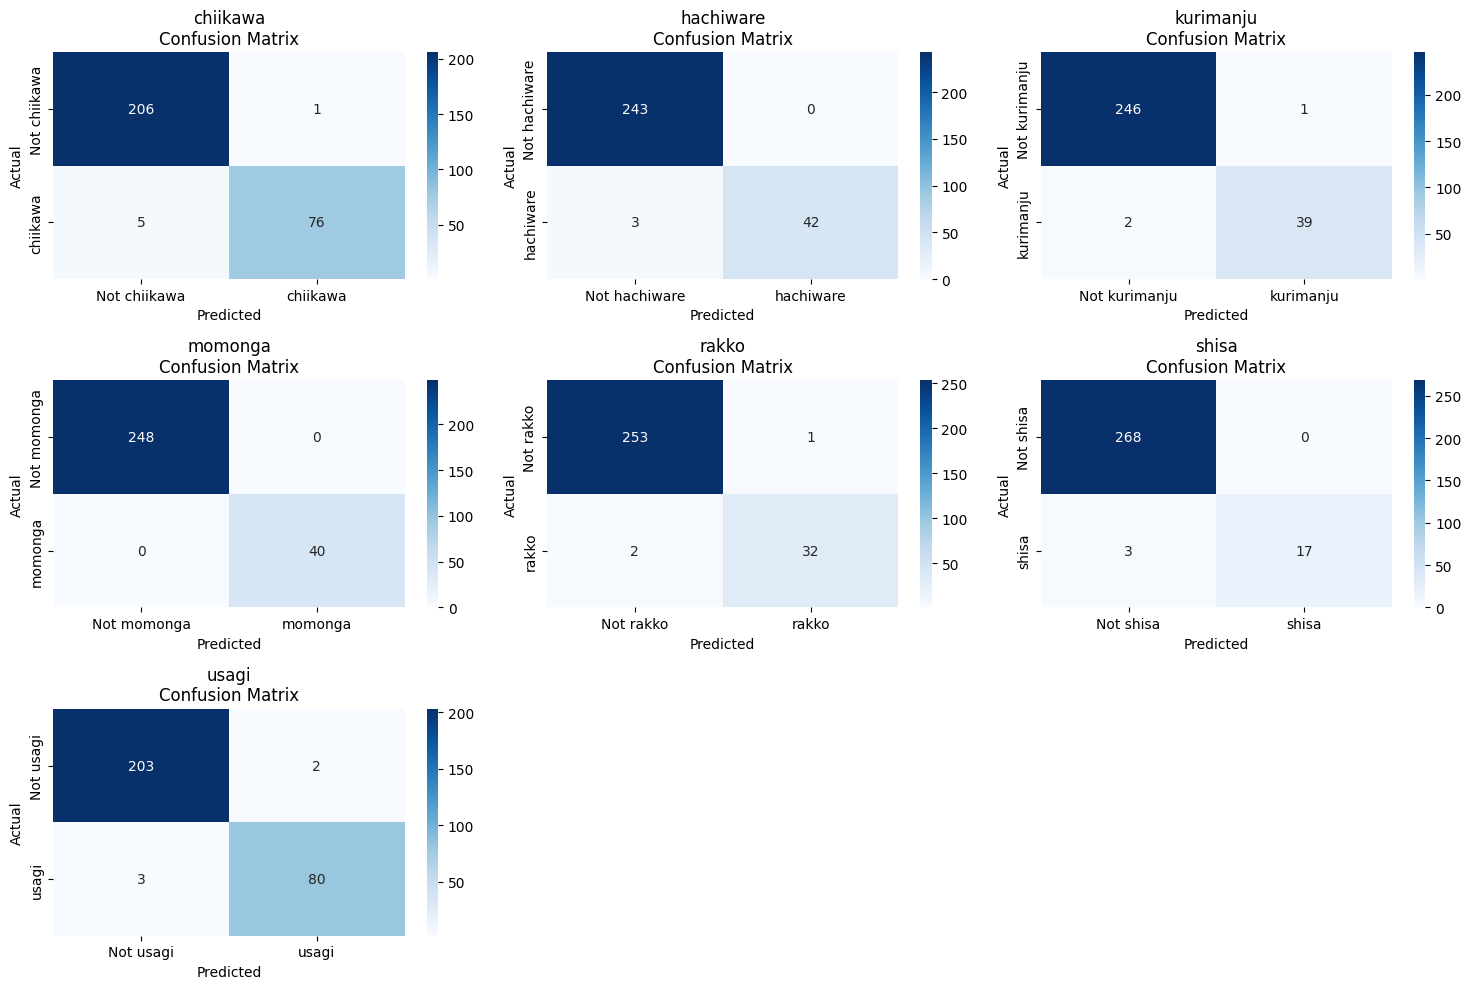


2. 每個類別的詳細指標:
       Class  TP   TN  FP  FN  Precision  Recall  F1-Score  Specificity  \
0   chiikawa  76  206   1   5      0.987   0.938     0.962        0.995   
1  hachiware  42  243   0   3      1.000   0.933     0.966        1.000   
2  kurimanju  39  246   1   2      0.975   0.951     0.963        0.996   
3    momonga  40  248   0   0      1.000   1.000     1.000        1.000   
4      rakko  32  253   1   2      0.970   0.941     0.955        0.996   
5      shisa  17  268   0   3      1.000   0.850     0.919        1.000   
6      usagi  80  203   2   3      0.976   0.964     0.970        0.990   

   Accuracy  
0     0.979  
1     0.990  
2     0.990  
3     1.000  
4     0.990  
5     0.990  
6     0.983  

3. 標籤頻率比較:


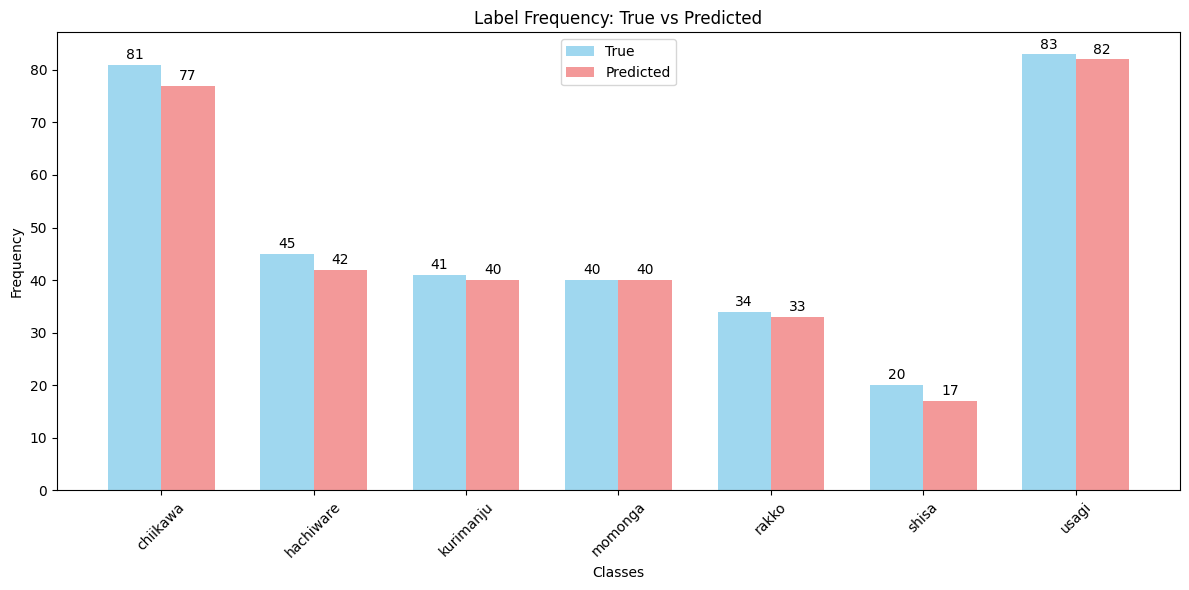


4. 標籤共現矩陣:


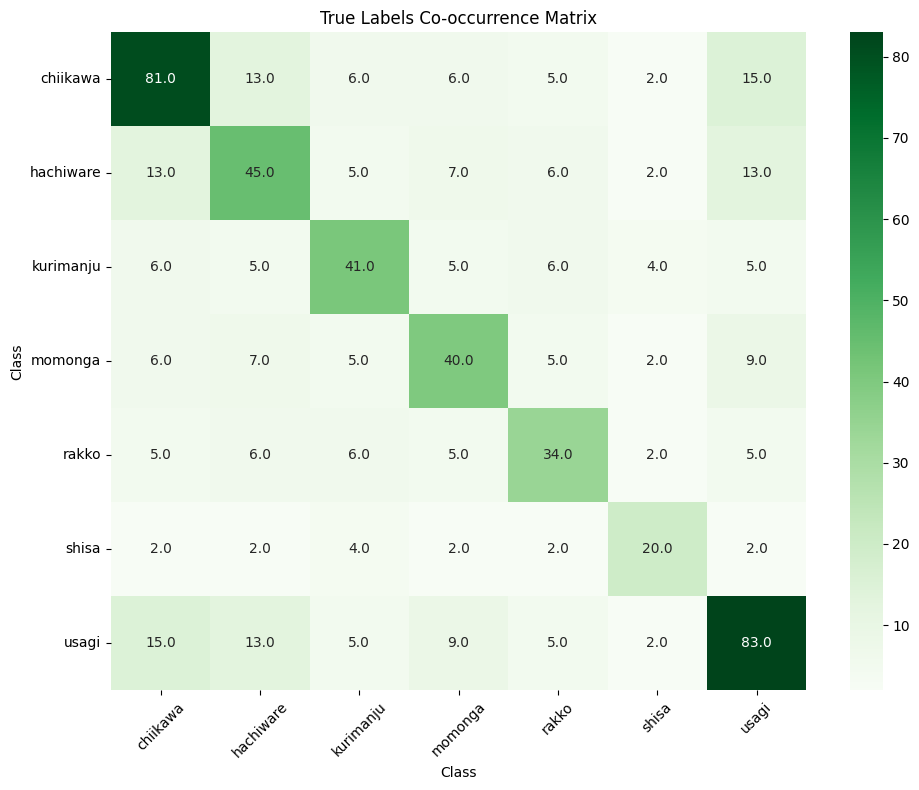

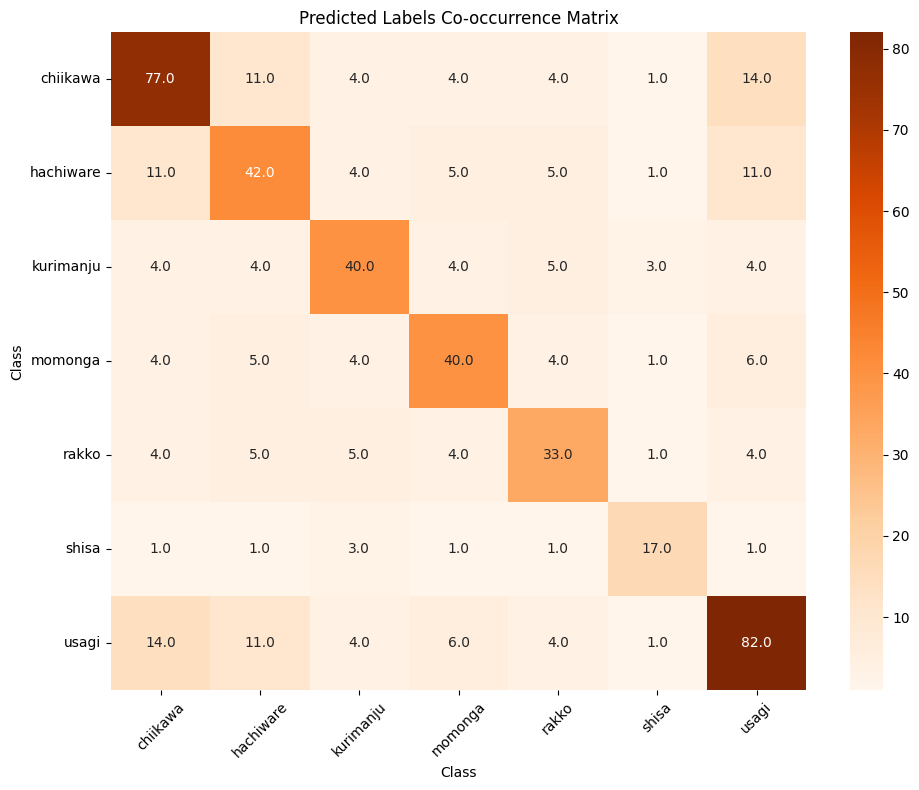


5. 子集준確度分析:


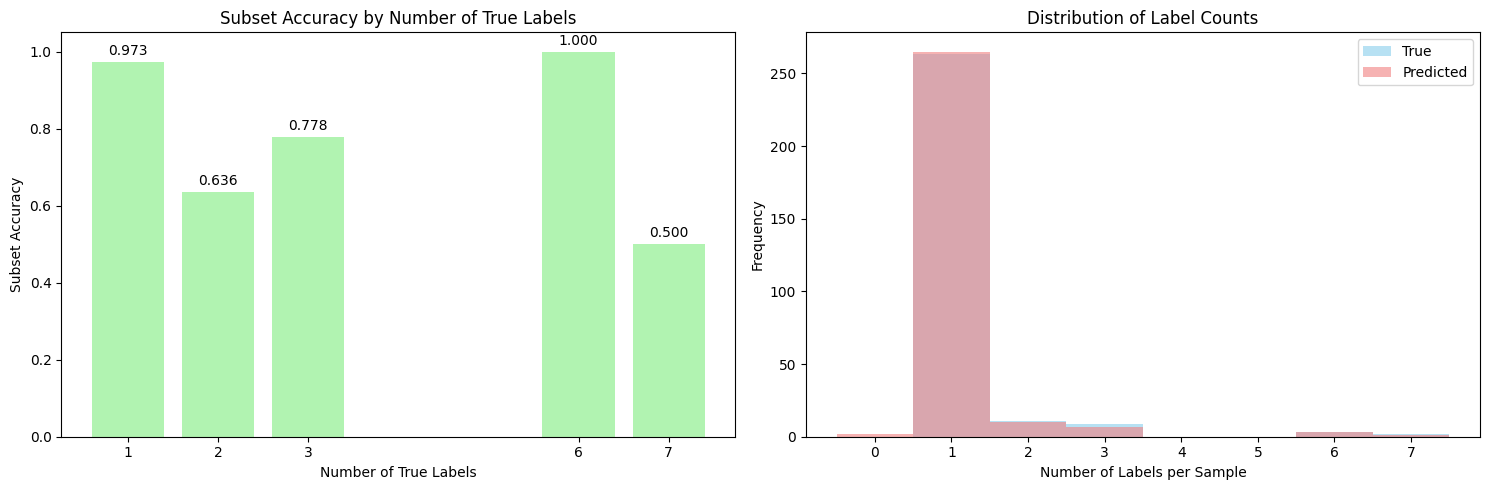

Overall Subset Accuracy: 0.951


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import pandas as pd

def plot_multilabel_confusion_matrices(y_true, y_pred, class_names, figsize=(15, 10)):
    """
    為每個類別繪製二元混淆矩陣 (每個類別 vs 其他所有類別)
    """
    # 計算多標籤混淆矩陣
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    
    n_classes = len(class_names)
    cols = 3
    rows = (n_classes + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if n_classes > 1 else [axes]
    
    for i, class_name in enumerate(class_names):
        cm = mcm[i]
        
        # 繪製熱力圖
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Not ' + class_name, class_name],
                   yticklabels=['Not ' + class_name, class_name])
        axes[i].set_title(f'{class_name}\nConfusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    # 隱藏多餘的子圖
    for i in range(n_classes, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return mcm


def plot_label_cooccurrence_matrix(y_true, y_pred, class_names, plot_type='both'):
    """
    繪製標籤共現矩陣 (顯示哪些標籤經常一起出現)
    """
    if plot_type in ['true', 'both']:
        # 真實標籤的共現矩陣
        true_cooc = np.dot(y_true.T, y_true)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(true_cooc, annot=True, fmt='.1f', cmap='Greens',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('True Labels Co-occurrence Matrix')
        plt.xlabel('Class')
        plt.ylabel('Class')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    if plot_type in ['pred', 'both']:
        # 預測標籤的共現矩陣
        pred_cooc = np.dot(y_pred.T, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(pred_cooc, annot=True, fmt='.1f', cmap='Oranges',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Predicted Labels Co-occurrence Matrix')
        plt.xlabel('Class')
        plt.ylabel('Class')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()


def plot_label_frequency_comparison(y_true, y_pred, class_names):
    """
    比較真實標籤和預測標籤的頻率分布
    """
    true_freq = y_true.sum(axis=0)
    pred_freq = y_pred.sum(axis=0)
    
    x = np.arange(len(class_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width/2, true_freq, width, label='True', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, pred_freq, width, label='Predicted', alpha=0.8, color='lightcoral')
    
    ax.set_xlabel('Classes')
    ax.set_ylabel('Frequency')
    ax.set_title('Label Frequency: True vs Predicted')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()
    
    # 在柱狀圖上顯示數值
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


def compute_multilabel_metrics_per_class(y_true, y_pred, class_names):
    """
    計算每個類別的詳細指標
    """
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    
    metrics_data = []
    
    for i, class_name in enumerate(class_names):
        tn, fp, fn, tp = mcm[i].ravel()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        metrics_data.append({
            'Class': class_name,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Specificity': specificity,
            'Accuracy': accuracy
        })
    
    df = pd.DataFrame(metrics_data)
    return df


def plot_subset_accuracy_analysis(y_true, y_pred, class_names):
    """
    分析子集準確度 (exact match) 的詳細情況
    """
    # 計算每個樣本的匹配情況
    exact_matches = np.all(y_true == y_pred, axis=1)
    subset_accuracy = np.mean(exact_matches)
    
    # 統計不同標籤數量的準確度
    true_label_counts = y_true.sum(axis=1)
    pred_label_counts = y_pred.sum(axis=1)
    
    # 按真實標籤數量分組的準確度
    unique_counts = np.unique(true_label_counts)
    accuracy_by_count = []
    
    for count in unique_counts:
        mask = (true_label_counts == count)
        if np.any(mask):
            acc = np.mean(exact_matches[mask])
            accuracy_by_count.append(acc)
        else:
            accuracy_by_count.append(0)
    
    # 繪製圖表
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 子圖1: 按標籤數量的準確度
    ax1.bar(unique_counts, accuracy_by_count, alpha=0.7, color='lightgreen')
    ax1.set_xlabel('Number of True Labels')
    ax1.set_ylabel('Subset Accuracy')
    ax1.set_title('Subset Accuracy by Number of True Labels')
    ax1.set_xticks(unique_counts)
    
    # 在柱狀圖上顯示數值
    for i, acc in enumerate(accuracy_by_count):
        ax1.text(unique_counts[i], acc + 0.01, f'{acc:.3f}', 
                ha='center', va='bottom')
    
    # 子圖2: 標籤數量分布比較
    bins = np.arange(0, max(max(true_label_counts), max(pred_label_counts)) + 2) - 0.5
    ax2.hist(true_label_counts, bins=bins, alpha=0.6, label='True', color='skyblue')
    ax2.hist(pred_label_counts, bins=bins, alpha=0.6, label='Predicted', color='lightcoral')
    ax2.set_xlabel('Number of Labels per Sample')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Label Counts')
    ax2.legend()
    ax2.set_xticks(range(int(max(max(true_label_counts), max(pred_label_counts))) + 1))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Overall Subset Accuracy: {subset_accuracy:.3f}")
    return subset_accuracy


def comprehensive_multilabel_analysis(y_true, y_pred, class_names):
    """
    完整的多標籤分類分析
    """
    print("=== 多標籤分類完整分析 ===\n")
    
    # 1. 每個類別的混淆矩陣
    print("1. 每個類別的二元混淆矩陣:")
    mcm = plot_multilabel_confusion_matrices(y_true, y_pred, class_names)
    
    # 2. 每個類別的詳細指標
    print("\n2. 每個類別的詳細指標:")
    metrics_df = compute_multilabel_metrics_per_class(y_true, y_pred, class_names)
    print(metrics_df.round(3))
    
    # 3. 標籤頻率比較
    print("\n3. 標籤頻率比較:")
    plot_label_frequency_comparison(y_true, y_pred, class_names)
    
    # 4. 標籤共現分析
    print("\n4. 標籤共現矩陣:")
    plot_label_cooccurrence_matrix(y_true, y_pred, class_names)
    
    # 5. 子集準確度分析
    print("\n5. 子集준確度分析:")
    subset_acc = plot_subset_accuracy_analysis(y_true, y_pred, class_names)
    
    return {
        'confusion_matrices': mcm,
        'metrics_per_class': metrics_df,
        'subset_accuracy': subset_acc
    }


# 修改原評估函數以包含多標籤分析
def evaluate_model_with_multilabel_analysis(model, test_loader, class_names, device='cuda', 
                                          threshold=0.5, show_analysis=True):
    """
    評估模型並進行完整的多標籤分析
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = torch.sigmoid(outputs)
            predictions = (probs > threshold).float()

            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

    if show_analysis:
        # 進行完整的多標籤分析
        analysis_results = comprehensive_multilabel_analysis(
            all_labels, all_predictions, class_names
        )
        return all_predictions, all_labels, all_probs, analysis_results
    else:
        return all_predictions, all_labels, all_probs


def load_predictions_from_csv(csv_file=None, pred_csv=None, true_csv=None, class_names=None):
    """
    從 CSV 檔案讀取預測結果和真實標籤
    
    方法1 - 單一 CSV 檔案格式:
    image_name,predicted_labels,true_labels
    case_001,0 2,0 2
    case_002,1 4 5,1 4
    case_003,,0 1 3
    
    方法2 - 分開的兩個 CSV 檔案:
    pred.csv: image_name,labels
    true.csv: image_name,labels
    """
    
    if csv_file is not None:
        # 方法1: 單一檔案包含兩者
        df = pd.read_csv(csv_file)
        n_samples = len(df)
        n_classes = len(class_names)
        
        y_pred = np.zeros((n_samples, n_classes))
        y_true = np.zeros((n_samples, n_classes))
        
        for i, row in df.iterrows():
            # 處理預測標籤
            if pd.notna(row['predicted_labels']) and str(row['predicted_labels']).strip():
                pred_indices = [int(x) for x in str(row['predicted_labels']).split()]
                y_pred[i, pred_indices] = 1
            
            # 處理真實標籤
            if pd.notna(row['true_labels']) and str(row['true_labels']).strip():
                true_indices = [int(x) for x in str(row['true_labels']).split()]
                y_true[i, true_indices] = 1
        
        return y_true, y_pred
    
    elif pred_csv is not None and true_csv is not None:
        # 方法2: 分開的兩個檔案
        pred_df = pd.read_csv(pred_csv)
        true_df = pd.read_csv(true_csv)
        
        # 確保兩個檔案有相同的 image_name 順序
        pred_df = pred_df.sort_values('image_name').reset_index(drop=True)
        true_df = true_df.sort_values('image_name').reset_index(drop=True)
        
        # 檢查 image_name 是否匹配
        if not pred_df['image_name'].equals(true_df['image_name']):
            print("警告: 預測檔案和真實標籤檔案的 image_name 不完全匹配!")
            # 取交集
            common_ids = set(pred_df['image_name']) & set(true_df['image_name'])
            pred_df = pred_df[pred_df['image_name'].isin(common_ids)].sort_values('image_name').reset_index(drop=True)
            true_df = true_df[true_df['image_name'].isin(common_ids)].sort_values('image_name').reset_index(drop=True)
            print(f"使用共同的 {len(common_ids)} 個案例")
        
        n_samples = len(pred_df)
        n_classes = len(class_names)
        
        y_pred = np.zeros((n_samples, n_classes))
        y_true = np.zeros((n_samples, n_classes))
        
        # 處理預測標籤
        for i, row in pred_df.iterrows():
            if pd.notna(row['labels']) and str(row['labels']).strip():
                pred_indices = [int(x) for x in str(row['labels']).split()]
                y_pred[i, pred_indices] = 1
        
        # 處理真實標籤
        for i, row in true_df.iterrows():
            if pd.notna(row['labels']) and str(row['labels']).strip():
                true_indices = [int(x) for x in str(row['labels']).split()]
                y_true[i, true_indices] = 1
        
        return y_true, y_pred
    
    else:
        raise ValueError("請提供 csv_file 或 (pred_csv 和 true_csv)")


def load_predictions_from_separate_files(pred_csv, true_csv, class_names):
    """
    從兩個分開的 CSV 檔案讀取預測結果和真實標籤
    
    兩個檔案格式都是:
    image_name,labels
    case_001,0 2
    case_002,1 4 5
    case_003,
    """
    return load_predictions_from_csv(pred_csv=pred_csv, true_csv=true_csv, class_names=class_names)

def analyze_predictions_from_csv(csv_file=None, pred_csv=None, true_csv=None, class_names=None):
    """
    從 CSV 檔案進行多標籤分析
    
    使用方法:
    1. 單一檔案: analyze_predictions_from_csv(csv_file='combined.csv', class_names=class_names)
    2. 分開檔案: analyze_predictions_from_csv(pred_csv='pred.csv', true_csv='true.csv', class_names=class_names)
    """
    if csv_file is not None:
        print(f"從單一 CSV 檔案讀取預測結果: {csv_file}")
        y_true, y_pred = load_predictions_from_csv(csv_file=csv_file, class_names=class_names)
    elif pred_csv is not None and true_csv is not None:
        print(f"從分開的 CSV 檔案讀取預測結果:")
        print(f"  預測檔案: {pred_csv}")
        print(f"  真實標籤檔案: {true_csv}")
        y_true, y_pred = load_predictions_from_csv(pred_csv=pred_csv, true_csv=true_csv, class_names=class_names)
    else:
        raise ValueError("請提供 csv_file 或 (pred_csv 和 true_csv)")
    
    print(f"讀取了 {len(y_true)} 個樣本，{len(class_names)} 個類別")
    
    # 進行完整分析
    return comprehensive_multilabel_analysis(y_true, y_pred, class_names)

# 使用範例
"""
class_names = ['chiikawa', 'hachiware', 'kurimanju', 'momonga', 'rakko', 'shisa', 'usagi']

# 方法1: 從模型直接評估
predictions, labels, probs, analysis = evaluate_model_with_multilabel_analysis(
    model=model,
    test_loader=test_loader,
    class_names=class_names,
    device='cuda',
    threshold=0.5,
    show_analysis=True
)

# 方法2: 從單一 CSV 檔案分析（包含預測和真實標籤）
analysis_results = analyze_predictions_from_csv(
    csv_file='predictions.csv', 
    class_names=class_names
)

# 方法3: 從兩個分開的 CSV 檔案分析
analysis_results = analyze_predictions_from_csv(
    pred_csv='predictions.csv',
    true_csv='ground_truth.csv', 
    class_names=class_names
)

# 方法4: 手動載入後分析
# 單一檔案
y_true, y_pred = load_predictions_from_csv(csv_file='combined.csv', class_names=class_names)

# 或分開的檔案
y_true, y_pred = load_predictions_from_csv(pred_csv='pred.csv', true_csv='true.csv', class_names=class_names)

# 然後分析
analysis_results = comprehensive_multilabel_analysis(y_true, y_pred, class_names)
"""

class_names = ['chiikawa', 'hachiware', 'kurimanju', 'momonga', 'rakko', 'shisa', 'usagi']

# # 如果是單一檔案
# analysis = analyze_predictions_from_csv(
#     csv_file='combined_results.csv', 
#     class_names=class_names
# )

# 如果是兩個分開的檔案
analysis = analyze_predictions_from_csv(
    pred_csv='test_predictions.csv',
    true_csv='ground_truth.csv', 
    class_names=class_names
)